# Sequence+v1.0

**Goal**: Build a model that can predict the total run value for any given *two* pitch sequence<br>
**Author**: Jensen Holm <br>
**Date**: October / November 2024

In [1]:
import statcast_pitches
import plotly.express as px
from plotnine import *
import polars as pl
import polars.selectors as cs
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
import optuna
import joblib
import pybaseball

DATA_DIR = os.path.join("..", "data")

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Loading Data

Using all pitches thrown in the statcast-era (2015-present) as our data for this model. <br>
I will also be using `../data/run_values.csv` for calculating run values of each pitch, this data represents 2024 only.

**Data Dictionary**: [link](https://baseballsavant.mlb.com/csv-docs) <br>
**statcast_pitches package info**: [link](https://github.com/Jensen-holm/statcast-era-pitches)

In [2]:
# use statcast pitches to get all pitches thrown in since hawkeye began
pitches_lf: pl.LazyFrame = (statcast_pitches.load()
                            .filter(pl.col("game_date").dt.year().is_in([2020, 2021, 2022, 2023, 2024])))

latest_date = pitches_lf.select("game_date").max().collect().item().date()
earliest_date = pitches_lf.select("game_date").min().collect().item().date()
n_pitches = pitches_lf.select(pl.len()).collect().item()

run_values_24_lf = pl.scan_csv(
    os.path.join(DATA_DIR, "run_values.csv"),
)

print(f"N Pitches: {n_pitches:,}")
print(f"Date Range: {earliest_date} - {latest_date}")

N Pitches: 3,349,317
Date Range: 2020-07-23 - 2024-10-30


# Feature Engineering

adding the following features to `pitches_df`

| Feature Name | Description |
|------|-------------|
| **delta_run_exp** | run value associated with the pitch outcome from `run_values_24`|
| **x_0.120** | position in the x dimension of the pitch at decision time (~0.12s) |
| **y_0.120** | position in the y dimension of the pitch at decision time (~0.12s) |
| **z_0.120** | position in the z dimension of the pitch at decision time (~0.12s) |
| **x_0.167** | position in the x dimension of the pitch at commit time (~0.167s) |
| **y_0.167** | position in the y dimension of the pitch at commit time (~0.167s) |
| **z_0.167** | position in the z dimension of the pitch at commit time (~0.167s) |
| **velocity_diff** | difference in velocity between pitches in a two pitch sequence |
| **effective_velocity_diff** | difference in effective velocity between pitches in a two pitch sequence |
| **pfx_x_diff** | difference in horizontal movement between pitches in a two pitch sequence |
| **pfx_z_diff** | difference in vertical movement between pitches in a two pitch sequence |
| **3d_dist_0.167** | 3D euclidean distance between pitches in a two pitch sequence 0.167 seconds after release |
| **3d_dist_0.120** | 3D distance between pitches in a two pitch sequence at 0.120 seconds after release |
| **distance** | 2D euclidean distance between pitch locations when crossing the plate in a two pitch sequence |
| **seq_delta_run_exp** | sum of `delta_run_exp` in a two pitch sequence |
| **plate_x_diff** | difference in plate_x between pitches in a two pitch sequence |
| **plate_z_diff** | difference in plate_z between pitches in a two pitch sequence |

On top of adding these features, attributes from LHP should be mirrored as if they were thrown by a RHP for consistency

## Expected Run Value

Joining the expected runs from run_values_24 to the pitches dataframe so that each pitch has an associated run value.

**New Features**

- `delta_run_exp`

In [3]:
def _standardize_events(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Standardizes events to run_values.csv format"""
    event_mapping = {
        "single": "single",
        "double": "double",
        "triple": "triple",
        "home_run": "home_run",
        "field_out": "field_out",
        "strikeout": "strikeout",
        "walk": "walk",
        "hit_by_pitch": "hit_by_pitch"
    }

    description_mapping = {
        "called_strike": "called_strike",
        "swinging_strike": "swinging_strike",
        "ball": "ball",
        "foul": "foul",
        "hit_by_pitch": "hit_by_pitch"
    }
    return lf.with_columns([
        # First try to map the event
        pl.when(pl.col("events").is_in(event_mapping.keys()))
        .then(pl.col("events"))
        # If no event match, try to map the description
        .otherwise(
            pl.when(pl.col("description").is_in(description_mapping.keys()))
            .then(pl.col("description"))
            # If neither matches, mark as null
            .otherwise(None)
        ).alias("standardized_event")
    ])

def add_pitch_run_value(pitches_lf: pl.LazyFrame, run_values_lf: pl.LazyFrame) -> pl.LazyFrame:

    def join_run_values(df: pl.LazyFrame) -> pl.LazyFrame:
        return (df
                .join(
                    other=run_values_lf,
                    left_on=["standardized_event", "balls", "strikes"],
                    right_on=["event", "balls", "strikes"],
                    how="left",
                )
                # Handle missing run values
                .with_columns([
                    pl.when(pl.col("delta_run_exp").is_null())
                    .then(0.0)  # Default to 0 run value for unknown events
                    .otherwise(pl.col("delta_run_exp"))
                    .alias("delta_run_exp")
                ]))

    return (pitches_lf
            .pipe(_standardize_events)
            .pipe(join_run_values))


pitches_xRV_lf = (pitches_lf
                  .pipe(add_pitch_run_value, run_values_24_lf))

(pitches_xRV_lf
    .select(
        "pitch_type",
        "description",
        "balls",
        "strikes",
        "delta_run_exp",
    )
    .describe())

statistic,pitch_type,description,balls,strikes,delta_run_exp
str,str,str,f64,f64,f64
"""count""","""3275273""","""3349317""",3.349317e6,3.349317e6,3.349317e6
"""null_count""","""74044""","""0""",0.0,0.0,0.0
"""mean""",null,null,0.869556,0.891261,0.000012
"""std""",null,null,0.967163,0.828939,0.236284
"""min""","""CH""","""ball""",0.0,0.0,-1.537
"""25%""",null,null,0.0,0.0,-0.063
"""50%""",null,null,1.0,1.0,0.0
"""75%""",null,null,1.0,2.0,0.034
"""max""","""SV""","""swinging_strike_blocked""",4.0,3.0,3.65


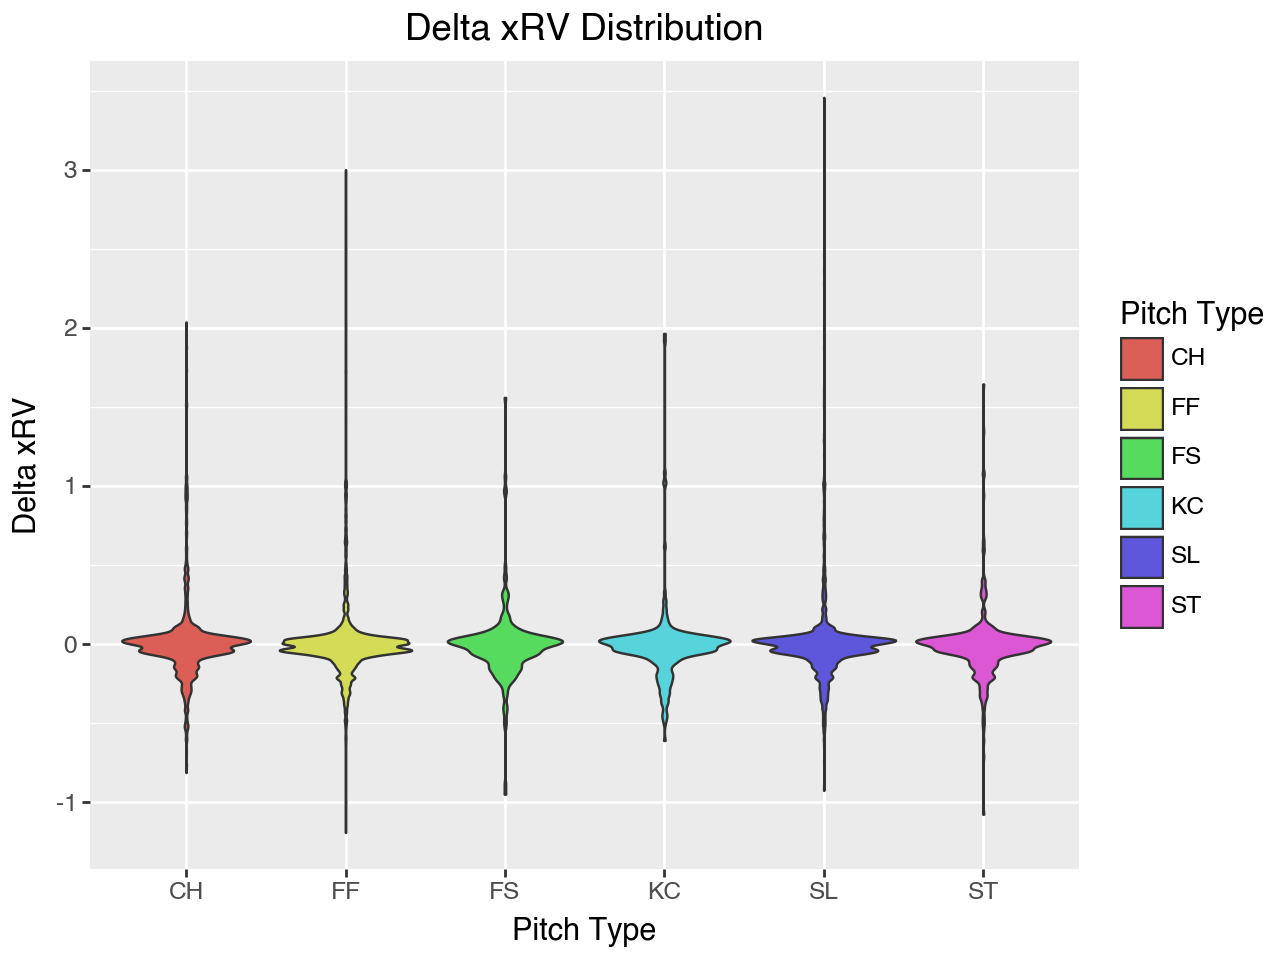

In [4]:
rv_dist = (
    ggplot(
        pitches_xRV_lf.select("delta_run_exp", "pitch_type")
        .filter(pl.col("pitch_type").is_in(["FF", "FS", "ST", "KC", "CH", "SL"]))
        .collect()
        .sample(n=10000),
        aes(x="pitch_type", y="delta_run_exp", fill="pitch_type")
    )
    + geom_violin()
    + labs(
        title="Delta xRV Distribution",
        x="Pitch Type",
        y="Delta xRV",
        fill="Pitch Type",
    )
)

rv_dist.show()

In order to keep it simple, I am mirroring the movement and the horizontal release position of each pitch thrown from LHP, to as if it were thrown by RHP.

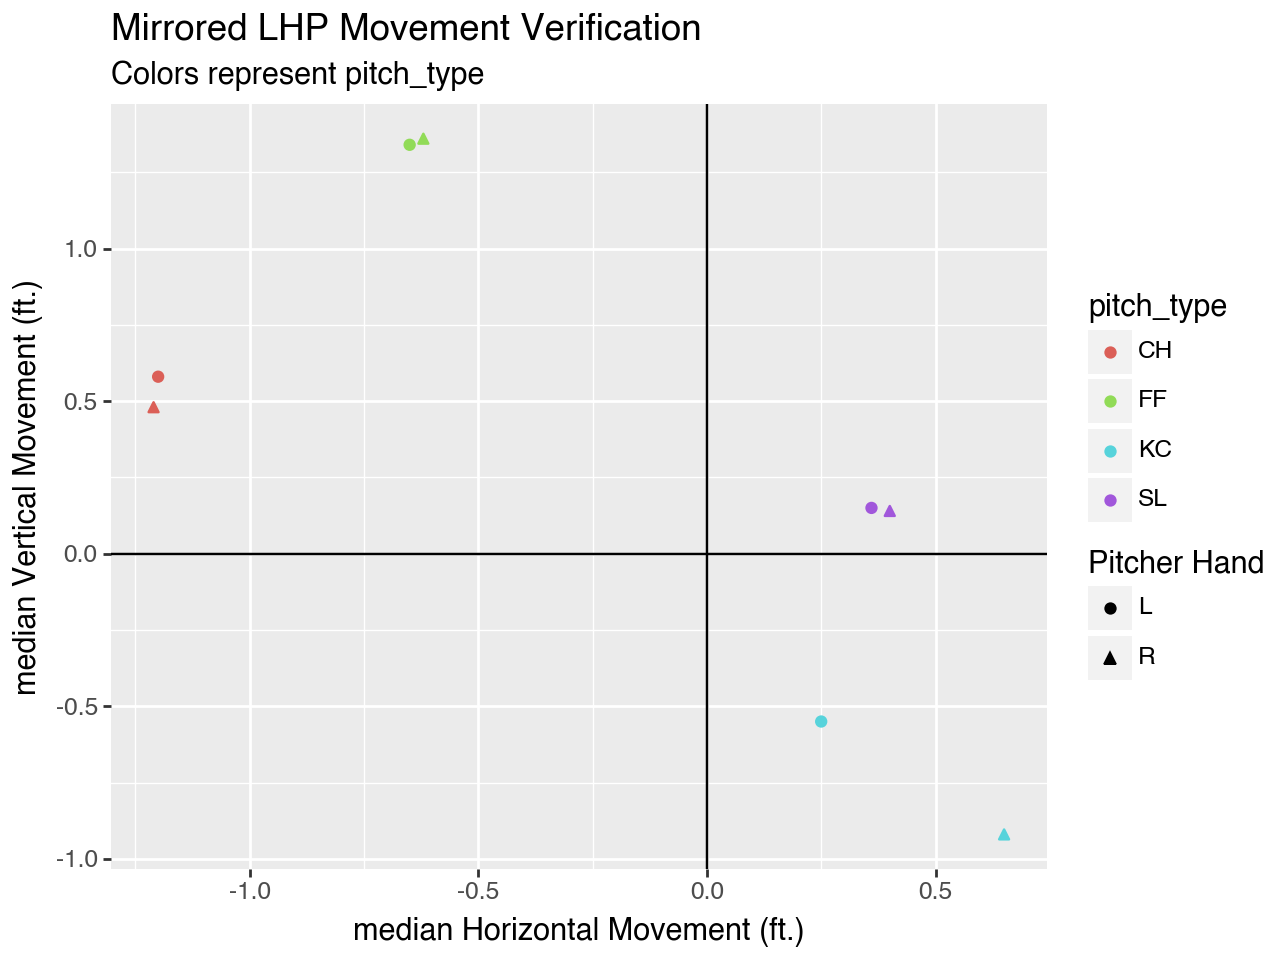

In [5]:
def mirror_lhp_to_rhp(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        # mirror LHP horizontal movement
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("pfx_x"))
        .otherwise(pl.col("pfx_x")),

        # also mirror the horizontal release point
        # (release_pos_x is from catcher perspective)
        pl.when(pl.col("p_throws") == "L")
        .then(-pl.col("release_pos_x"))
        .otherwise(pl.col("release_pos_x")),
    )

mirrored_pitches_lf = pitches_xRV_lf.pipe(mirror_lhp_to_rhp)

# for verification
movement_plt = (
    ggplot(
        mirrored_pitches_lf
        .filter(pl.col("pitch_type").is_in(["FF", "KC", "SL", "CH"]))
        .group_by("pitch_type", "p_throws")
        .agg(
            pl.col("pfx_x").median().alias("median_pfx_x"),
            pl.col("pfx_z").median().alias("median_pfx_z"),
        ).collect(),
        aes(x="median_pfx_x", y="median_pfx_z", color="pitch_type", shape="p_throws"))
    + geom_point()
    + geom_vline(xintercept=0)
    + geom_hline(yintercept=0)
    + labs(
        title="Mirrored LHP Movement Verification",
        x="median Horizontal Movement (ft.)",
        y="median Vertical Movement (ft.)",
        shape="Pitcher Hand",
        subtitle="Colors represent pitch_type",
    )
)

movement_plt.show()

Horizontal movement profiles are mirrored now!

## 3D Pitch Location Estimation

Now to add ball positions in 3D space at both [decision time]() (0.12s) & [commit time]() (0.167s)

### Step 1: Time to 50ft. from home plate

Estimate the time it took the baseball to travel from release point to 50ft from home plate (the point where we have measurements for a &v in x, y, z dimensions)

$t_{50} = \frac{(60 + 6/12) - 50 - extension}{vft * 1.05}$

Where ...
- $extension = $ distance from the rubber where the pitch was released<br>
- $vft = $ release_speed in ft/s

I multiply the velocity by 1.05 in order to dialate the time by 5%. This makes our estimation of position more accurate because it helps account for error that we get from assuming that acceleration is constant in the kinematic equations for displacement.

**New Features**
- `t50`: estimated time it took the ball to get to 50ft. from home plate
- `release_pos_y`: release position in the y dimension converted to feet


In [6]:
def displacement(p0, v0, t, a):
    return p0 + v0 * t + 0.5 * a * t**2

def convert_release_y_to_ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(pl.col("release_pos_y") / 12)

def estimate_time_to_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        ((((60 + 6/12) - 50) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t50")
    )

time_to_50ft_lf = (pitches_xRV_lf
                   .pipe(convert_release_y_to_ft)
                   .pipe(estimate_time_to_50ft))

(time_to_50ft_lf
    .select("release_pos_y", "t50")
    .describe())

statistic,release_pos_y,t50
str,f64,f64
"""count""",3.273821e6,3.267351e6
"""null_count""",75496.0,81966.0
"""mean""",4.510473,0.030309
"""std""",0.038164,0.004457
"""min""",3.943333,-0.011455
"""25%""",4.485833,0.027378
"""50%""",4.51,0.030015
"""75%""",4.535833,0.032888
"""max""",4.8075,0.147386


### Step 2: x, y, & z positions at 50ft. from home plate

For this I use the kinematic equations with the acceleration, velocity and now our time estimate, $t_{50}$, to calculate displacement in each dimension.

$d_{50} = r_{dim} + v_{dim} * t_{50} * \frac{1}{2} * a_{dim} * t_{50}^2$

Where ...
- $r_{dim} = $ release position in x, y or z dimension
- $v_{dim} = $ velocity at 50ft. from home plate in x, y or z dimension
- $a_{dim} = $ acceleration at 50ft. from home plate in x, y or z dimension
- $t_{50} = $ estimated time that it took to get to 50ft. from home plate from step 1

**New Features**
- `x50`: position in the x dimension when the ball is 50ft. from home plate
- `y50`: position in the y dimension when the ball is 50ft. from home plate
- `z50`: position in the z dimension when the ball is 50ft. from home plate


In [7]:
def estimate_pos_at_50ft(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"release_pos_{d}"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t50"),
        ).alias(f"{d}50")
        for d in ["x", "y", "z"]
    )

pos_at_50ft_lf = time_to_50ft_lf.pipe(estimate_pos_at_50ft)

(pos_at_50ft_lf
    .select("x50", "y50", "z50")
    .describe())

statistic,x50,y50,z50
str,f64,f64,f64
"""count""",3.267351e6,3.267351e6,3.267351e6
"""null_count""",81966.0,81966.0,81966.0
"""mean""",-0.733091,0.62623,5.677062
"""std""",1.705633,0.39354,0.503183
"""min""",-5.203945,-2.449655,1.036836
"""25%""",-1.936412,0.385009,5.422181
"""50%""",-1.355324,0.644951,5.709631
"""75%""",0.840564,0.901346,5.986481
"""max""",4.521722,5.5406,9.537938


### Step 3: Estimate 3D positions at commit time & decision time

Now we can make an estimate of where the ball is in all dimensions, at any given time. But I am interested specifically in 0.120 seconds after release (commit time), and 0.167 seconds after release (decision time).

For this I use the same formula that I used to esimate position at 50ft. from home plate, except I start from that 50ft. mark by calculating the difference in time between $t_{50}$ and $t_{i}$.

$d_{i} = p_{50} + v_{50} * (t_{50} - t_{i}) * \frac{1}{2} * a_{50} * (t_{50} - t_{i})^2$

Where ...
- $p_{50} = $ position in x, y, or z dimension at 50 ft. from home plate

I am assuming that both $v$ and $a$ are constant, again using a 5% time dilation as a crutch to help account for this.

**New Features**
- `x_0.120`: position in the x dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the y dimension at 0.120 seconds after release (commit time)
- `y_0.120`: position in the z dimension at 0.120 seconds after release (commit time)
- `x_0.167`: position in the x dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the y dimension at 0.120 seconds after release (decision time)
- `y_0.167`: position in the z dimension at 0.120 seconds after release (decision time)
- `t_plate`: estimated time that it takes the ball to reach home plate
- `x_plate`: position in the x dimension when the ball crossed the plate
- `y_plate`: position in the y dimension when the ball crossed the plate
- `z_plate`: position in the z dimension when the ball crossed the plate


In [8]:
def estimate_time_to_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        (((60 + 6/12) - pl.col("release_extension"))
        / ((pl.col("release_speed") * (5280/3600) * 1.05))).alias("t_plate")
    )

def estimate_ball_pos_at_plate(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=pl.col("t_plate") - pl.col("t50"),
        ).alias(f"{d}_plate")
        for d in ["x", "y", "z"]
    )

def estimate_ball_pos_at_t(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=t - pl.col("t50"),
        ).alias(f"{d}_{t:.3f}")
        for d in ["x", "y", "z"]
        for t in times
    )

TIMES = [0.120, 0.167]

ball_pos_lf = (pos_at_50ft_lf
               .pipe(estimate_time_to_plate)
               .pipe(estimate_ball_pos_at_plate)
               .pipe(estimate_ball_pos_at_t, TIMES))

(ball_pos_lf
    .select("t50", "x_0.120", "y_0.120", "z_0.120",
            "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate")
    .describe())

statistic,t50,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,x_plate,y_plate,z_plate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3.267351e6,3.267351e6,3.267351e6,3.267351e6,3.267351e6,3.267351e6,3.267351e6,3.267351e6,3.267351e6,3.267351e6
"""null_count""",81966.0,81966.0,81966.0,81966.0,81966.0,81966.0,81966.0,81966.0,81966.0,81966.0
"""mean""",0.030309,-0.526471,-10.891515,5.22945,-0.427037,-16.828183,4.920959,-0.005418,-44.812312,2.616632
"""std""",0.004457,1.279699,1.042835,0.486429,1.092266,1.43551,0.522797,0.78338,0.448776,0.894262
"""min""",-0.011455,-9.326163,-13.681389,-3.299011,-14.609828,-20.63631,-7.158099,-114.369224,-140.804898,-76.964296
"""25%""",0.027378,-1.429853,-11.723838,4.932507,-1.198617,-17.974188,4.583346,-0.530056,-45.104226,2.03255
"""50%""",0.030015,-0.923173,-11.049736,5.224253,-0.705097,-17.048448,4.903229,-0.004475,-44.806309,2.61775
"""75%""",0.032888,0.505488,-10.158555,5.52804,0.344841,-15.820425,5.241046,0.519643,-44.517405,3.203951
"""max""",0.147386,4.386514,-0.097775,9.172685,4.541119,-1.997461,9.883671,8.951553,-39.263614,13.698295


### Pitch Location Visualization

In order to make sure this is working, here I make a 3D scatter plot of 3 random pitches thrown by Yu Darvish in the 2024 season and their estimated positions at release, 50ft from home, commit time, decision time, and across the plate.

**Plot Line Color Legend**
- `Sweeper`: Purple
- `Splitter`: Yellow
- `Slider`: Green
- `Knuckle Curve`: Blue
- `Four Seam Fastball`: Red


In [9]:
pitch_types = ["KC", "FF", "FS", "SL", "ST"]
cols = ["pitch_type", "release_pos_x", "release_pos_y", "release_pos_z",
        "x50", "y50", "z50", "x_0.120", "y_0.120", "z_0.120",
        "x_0.167", "y_0.167", "z_0.167", "x_plate", "y_plate", "z_plate"]

extra_times = np.arange(0, 0.5, 0.05).tolist()
extra_time_cols = [f"{d}_{t:.3f}"
                   for d in ["x", "y", "z"]
                   for t in extra_times]

# for the visualization, I am going to use a lot more time intervals
# for position estimation to get a smoother curve
sample_pitch_df = (ball_pos_lf
                   .filter(pl.col("game_date").dt.year() == 2024)
                   .filter(pl.col("pitch_type").is_in(pitch_types))
                   .filter(pl.col("player_name") == "Darvish, Yu")
                   .pipe(estimate_ball_pos_at_t, extra_times)
                   .drop_nulls(cols + extra_time_cols)
                   .group_by("pitch_type")
                   .agg(pl.col("*").sample(1, seed=40))
                   .select(cols + extra_time_cols)
                   .explode([pl.col(col)
                             for col in (cols + extra_time_cols)
                             if col != "pitch_type"])
                   .collect())


fig = px.scatter_3d()
colors = {"KC": "blue", "FF": "red", "FS": "yellow", "SL": "green", "ST": "purple"}
for pitch in sample_pitch_df.iter_rows(named=True):
    pitch_fig = px.line_3d(
        x=[pitch["release_pos_x"]] + [pitch[f"x_{t:.3f}"] for t in extra_times],
        y=[pitch["release_pos_y"]] + [pitch[f"y_{t:.3f}"] for t in extra_times],
        z=[pitch["release_pos_z"]] + [pitch[f"z_{t:.3f}"] for t in extra_times],
    )

    pitch_fig.update_traces(line=dict(color=colors[pitch["pitch_type"]]))
    fig.add_traces(pitch_fig.data)

fig.update_layout(title=dict(text="Random Yu Darvish Pitch Location Estimation"), showlegend=True)
fig.show()

## Location Estimation Error

Since I have the ground truth for release position, I can measure roughly how accurate the position estimation functions are by trying to estimate this release position in 3D space. I compute the mean euclidean distance between estimated release position and actual release position.

$3Deuclideandistance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}$

Looking at the results, depending on the pitch type, it is typically off by anywhere between .4 inches and .8 inches on average.

**New Features**
- `approx_release_pos_x`: approximated release position in the x dimension working back from 50ft.
- `approx_release_pos_y`: approximated release position in the y dimension working back from 50ft.
- `approx_release_pos_z`: approximated release position in the z dimension working back from 50ft.


In [10]:
def estimate_release_pos(lf: pl.LazyFrame) -> pl.LazyFrame:
    return lf.with_columns(
        displacement(
            p0=pl.col(f"{d}50"),
            v0=pl.col(f"v{d}0"),
            a=pl.col(f"a{d}"),
            t=-pl.col("t50"),
        ).alias(f"approx_release_pos_{d}")
        for d in ["x", "y", "z"]
    )

ball_pos_lf = ball_pos_lf.pipe(estimate_release_pos)


def euclidean_distance(*pts):
    return sum((pt[0] - pt[1]) ** 2 for pt in pts) ** 0.5


(ball_pos_lf
    .drop_nulls([col for col in ball_pos_lf.collect_schema().names() if "release" in col])
    .select("release_pos_x", "release_pos_y", "release_pos_z",
            "approx_release_pos_x", "approx_release_pos_y", "approx_release_pos_z",
            "pitch_type")
    .filter(pl.col("pitch_type").is_in(pitch_types))
    .group_by("pitch_type")
    .agg(
        (euclidean_distance(
            *[(pl.col(f"approx_release_pos_{d}"), pl.col(f"release_pos_{d}"))
            for d in ["x", "y", "z"]]
        ).mean() * 12).alias("mean_euclidean_error_in.")
    )
    .collect())

pitch_type,mean_euclidean_error_in.
str,f64
"""SL""",0.485008
"""FS""",0.455779
"""ST""",0.535768
"""FF""",0.334669
"""KC""",0.635302


## Sequence Features

**New Feautres**

Everything in the `prev_features` list will be added, I don't want to type all of that out.

**Note**

May or may not need this depending on what sort of model I end up building

In [11]:
# features that we are interested in with regards to two pitch sequences
prev_features = [
    "prev_pfx_x",
    "prev_pfx_z",
    "prev_x_0.120",
    "prev_y_0.120",
    "prev_z_0.120",
    "prev_x_0.167",
    "prev_y_0.167",
    "prev_z_0.167",
    "prev_release_pos_x",
    "prev_release_pos_y",
    "prev_release_pos_z",
    "prev_release_speed",
    "prev_effective_speed",
    "prev_release_spin_rate",
    "prev_delta_run_exp",
    "prev_x_plate",
    "prev_y_plate",
    "prev_z_plate",
    "prev_pitch_type",
    "prev_zone",
    "prev_ax",
    "prev_ay",
    "prev_az",
    "prev_vx0",
    "prev_vy0",
    "prev_vz0",
    "prev_plate_x",
    "prev_plate_z"
]

def two_pitch_sequences(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    # sort the data such that the pitches are in descending order
    sort_cols = ["pitcher", "game_date", "at_bat_number", "pitch_number"]
    sorted_lf = lf.sort(
        by=sort_cols,
        descending=[True] * len(sort_cols),
    )

    return (sorted_lf
        .with_columns([
            pl.col(feature)
            .shift(-1)
            .over(["pitcher", "at_bat_number"])
            .alias(f"prev_{feature}")
            for feature in [f.replace("prev_", "") for f in seq_features]
        ])
        .select(*sort_cols + seq_features)
        .join(other=lf, on=sort_cols, how="right")
    )

sequence_pitches_lf = (ball_pos_lf
                       .pipe(two_pitch_sequences, prev_features))

(sequence_pitches_lf
    .select(prev_features)
    .describe())

statistic,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,prev_z_0.120,prev_x_0.167,prev_y_0.167,prev_z_0.167,prev_release_pos_x,prev_release_pos_y,prev_release_pos_z,prev_release_speed,prev_effective_speed,prev_release_spin_rate,prev_delta_run_exp,prev_x_plate,prev_y_plate,prev_z_plate,prev_pitch_type,prev_zone,prev_ax,prev_ay,prev_az,prev_vx0,prev_vy0,prev_vz0,prev_plate_x,prev_plate_z
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3.201603e6,3.201614e6,3.195158e6,3.195158e6,3.195158e6,3.195158e6,3.195158e6,3.195158e6,3.201412e6,3.201412e6,3.201412e6,3.20162e6,3.194446e6,3.186042e6,3.267695e6,3.195158e6,3.195158e6,3.195158e6,"""3202778""",3.201622e6,3.201622e6,3.201622e6,3.201622e6,3.201622e6,3.201622e6,3.201622e6,3.201622e6,3.201622e6
"""null_count""",162386.0,162375.0,168831.0,168831.0,168831.0,168831.0,168831.0,168831.0,162577.0,162577.0,162577.0,162369.0,169543.0,177947.0,96294.0,168831.0,168831.0,168831.0,"""161211""",162367.0,162367.0,162367.0,162367.0,162367.0,162367.0,162367.0,162367.0,162367.0
"""mean""",-0.112982,0.616293,-0.526653,-10.894905,5.228902,-0.427122,-16.832773,4.920112,-0.800556,4.510354,5.802446,88.962916,89.099501,2249.963425,-0.001075,-0.004637,-44.810268,2.615609,null,9.116294,-2.169337,26.878937,-23.792669,2.370225,-129.389667,-3.894573,0.044419,2.282045
"""std""",0.88415,0.733639,1.279516,1.037517,0.486574,1.092187,1.428284,0.523063,1.859616,0.038039,0.541237,6.046484,6.207598,343.956743,0.225124,0.786724,0.448153,0.898664,null,4.228159,10.729811,4.018276,8.910998,5.810186,8.753645,3.06774,0.845183,0.978639
"""min""",-2.95,-2.56,-9.326163,-13.681389,-3.299011,-14.609828,-20.617553,-7.158099,-4.95,3.943333,0.76,30.4,26.8,4.0,-1.537,-114.369224,-140.804898,-76.964296,"""CH""",1.0,-193.953173,-337.555603,-124.677778,-94.025157,-152.524544,-70.284635,-65.16,-45.11
"""25%""",-0.86,0.16,-1.429878,-11.725938,4.931697,-1.198662,-17.977091,4.581821,-2.11,4.485833,5.54,84.6,84.8,2095.0,-0.061,-0.532809,-45.102457,2.026876,null,5.0,-11.259077,23.876503,-30.190661,-2.029698,-136.426827,-5.957593,-0.53,1.64
"""50%""",-0.18,0.69,-0.92272,-11.052585,5.223882,-0.704404,-17.052257,4.902679,-1.49,4.51,5.84,89.9,90.1,2277.0,0.0,-0.003526,-44.804665,2.616726,null,11.0,-2.175175,26.770976,-23.747176,4.002627,-130.698325,-4.000575,0.04,2.29
"""75%""",0.59,1.24,0.504602,-10.1606,5.528298,0.343897,-15.823139,5.241462,0.95,4.535833,6.14,93.8,94.0,2451.0,0.034,0.523934,-44.515526,3.207265,null,13.0,6.13869,29.85416,-15.967539,6.588025,-123.167268,-1.954798,0.61,2.93
"""max""",2.84,2.84,4.386514,-0.140021,9.172685,4.541119,-2.065677,9.883671,18.0,4.8075,8.11,105.1,107.7,3722.0,3.65,8.951553,-39.263614,13.698295,"""SV""",14.0,31.73382,100.050198,43.70545,24.111797,-40.960937,20.09525,10.2,13.58


## Adding 'diff' Features

**New Features**

For every feature in `prev_features`, we simply measure the difference in that feature between each pitch in a sequence. Each diff feature is its original name post fixed with 'diff'. Ex: `x_0.120_diff`, `y_0.120_diff` etc ...

In [12]:
def add_diff_features(lf: pl.LazyFrame, seq_features: list[str]) -> pl.LazyFrame:
    num_seq_features = set(lf
                           .select(seq_features)
                           .select(cs.numeric())
                           .collect_schema()
                           .names())

    return lf.with_columns(
        (pl.col(feature.replace("prev_", ""))
        - pl.col(feature)).alias(f"{feature.replace('prev_', '')}_diff")
        for feature in num_seq_features
    )

sequence_diff_pitches_lf = sequence_pitches_lf.pipe(add_diff_features, prev_features)

diff_features = [
    col for col in (sequence_diff_pitches_lf
                    .collect_schema().names())
    if col.endswith("_diff")
]

(sequence_diff_pitches_lf
    .select(*diff_features)
    .describe())

statistic,delta_run_exp_diff,vy0_diff,y_0.167_diff,plate_x_diff,z_plate_diff,release_speed_diff,z_0.120_diff,x_plate_diff,release_pos_z_diff,vz0_diff,effective_speed_diff,release_pos_x_diff,x_0.120_diff,az_diff,ay_diff,ax_diff,pfx_z_diff,release_pos_y_diff,pfx_x_diff,plate_z_diff,zone_diff,release_spin_rate_diff,z_0.167_diff,vx0_diff,y_0.120_diff,x_0.167_diff,y_plate_diff
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3.267695e6,3.18099e6,3.172503e6,3.18099e6,3.172503e6,3.180986e6,3.172503e6,3.172503e6,3.180734e6,3.18099e6,3.171022e6,3.180734e6,3.172503e6,3.18099e6,3.18099e6,3.18099e6,3.180979e6,3.180734e6,3.180962e6,3.18099e6,3.18099e6,3.15801e6,3.172503e6,3.18099e6,3.172503e6,3.172503e6,3.172503e6
"""null_count""",96294.0,182999.0,191486.0,182999.0,191486.0,183003.0,191486.0,191486.0,183255.0,182999.0,192967.0,183255.0,191486.0,182999.0,182999.0,182999.0,183010.0,183255.0,183027.0,182999.0,182999.0,205979.0,191486.0,182999.0,191486.0,191486.0,191486.0
"""mean""",0.001073,-0.007706,-0.001378,-0.000295,-0.001365,0.00483,-0.001319,-0.000178,-0.001495,0.002291,0.006805,0.000532,0.00042,-0.018083,0.001895,-0.004727,-0.00117,-0.00006,-0.000588,-0.001368,-0.030902,-0.785359,-0.001324,-0.000877,-0.001016,0.000355,0.000309
"""std""",0.326711,10.584952,1.72502,1.110322,1.209382,7.321575,0.427907,1.028251,0.161717,3.452713,7.430289,0.225699,0.415669,11.396701,4.605912,11.557404,0.944921,0.017783,1.024415,1.320492,5.951663,374.626336,0.55756,3.016972,1.252075,0.514475,0.285273
"""min""",-3.852,-90.793357,-14.847905,-10.55,-11.666142,-58.0,-3.887295,-9.390767,-5.49,-23.901739,-63.0,-15.72,-3.168973,-81.60219,-123.436211,-56.83021,-4.13,-0.58,-4.57,-11.89,-13.0,-3179.0,-4.444609,-21.934824,-10.759134,-3.502727,-12.429186
"""25%""",-0.099,-6.122783,-0.993614,-0.74,-0.791021,-4.3,-0.271596,-0.681569,-0.08,-2.172242,-4.2,-0.12,-0.266368,-5.668813,-2.849059,-5.249529,-0.44,-0.01,-0.48,-0.86,-4.0,-139.0,-0.356329,-1.929379,-0.722503,-0.333974,-0.168959
"""50%""",0.0,-0.045212,-0.007322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002217,0.023844,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.005474,0.0,0.0
"""75%""",0.09,6.134516,0.995253,0.74,0.782929,4.2,0.268931,0.681667,0.08,2.177479,4.2,0.12,0.267652,5.699798,2.792074,5.25463,0.44,0.01,0.48,0.85,4.0,138.0,0.353631,1.923655,0.72383,0.335031,0.170464
"""max""",3.887,88.516456,14.70033,65.32,80.325952,60.6,8.330738,114.666849,3.94,66.829288,63.1,15.77,11.003514,109.768685,373.262504,203.447463,5.36,0.579167,4.49,48.22,13.0,3151.0,11.943277,86.362339,10.684132,15.980613,96.997189


## 3D distance features

Using the euclidean distance function from earlier, I can create features that represent the distance between a pitch, and the previous pitch thrown in any given two pitch sequence.

In [13]:
def add_3D_distances(lf: pl.LazyFrame, times: list[float]) -> pl.LazyFrame:
    return lf.with_columns(
        # distance over the plate
        euclidean_distance(
            *[(pl.col(f"{d}_plate"), pl.col(f"prev_{d}_plate"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_plate"),

        # distance at release
        euclidean_distance(
            *[(pl.col(f"release_pos_{d}"), pl.col(f"prev_release_pos_{d}"))
              for d in ["x", "y", "z"]]
        ).alias("3d_dist_release"),

        # distances at given times after release
        *[euclidean_distance(
            *[(pl.col(f"{d}_{t:.3f}"), pl.col(f"prev_{d}_{t:.3f}"))
             for d in ["x", "y", "z"]]
        ).alias(f"3d_dist_{t:.3f}")
        for t in times]
    )

sequence_dist_pitches_lf = sequence_diff_pitches_lf.pipe(add_3D_distances, TIMES)

(sequence_dist_pitches_lf
    .select("3d_dist_0.120", "3d_dist_0.167",
            "3d_dist_plate", "3d_dist_release")
    .describe())

statistic,3d_dist_0.120,3d_dist_0.167,3d_dist_plate,3d_dist_release
str,f64,f64,f64,f64
"""count""",3.172503e6,3.172503e6,3.172503e6,3.180734e6
"""null_count""",191486.0,191486.0,191486.0,183255.0
"""mean""",1.143968,1.547879,1.413035,0.214067
"""std""",0.784165,1.074861,0.777573,0.177726
"""min""",0.0,0.0,0.0,0.0
"""25%""",0.483049,0.640718,0.842031,0.099121
"""50%""",0.963307,1.289585,1.29343,0.170002
"""75%""",1.68196,2.289395,1.852381,0.277849
"""max""",14.615147,20.706427,170.320872,15.812621


# Serializing the LazyFrame w/ Features

This will allow me to pick up at this point in a new notebook if I want to

In [14]:
sequence_dist_pitches_lf.serialize(
    os.path.join(DATA_DIR, "two_pitch_seqs_lf")
)

ball_pos_lf.serialize(
    os.path.join(DATA_DIR, "ball_pos_lf")
)

## Pre Processing


In [15]:
features = [
    "release_speed", "release_pos_x", "release_pos_y", "release_pos_z",
    "3d_dist_plate", "3d_dist_release", "3d_dist_0.120", "3d_dist_0.167",
    "ax", "ay", "az", "vx0", "vy0", "vz0", "x50", "y50", "z50", 
    "plate_x", "plate_z", "x_plate", "y_plate", "z_plate", "x_0.120", "y_0.120", "z_0.120",
    "x_0.167", "y_0.167", "z_0.167", 
    "pitch_type", "zone", "delta_run_exp",
] + prev_features + diff_features

RESPONSE = "seq_delta_run_exp"

two_seqs_df = (sequence_dist_pitches_lf
               .with_columns((pl.col("delta_run_exp") 
                              + pl.col("prev_delta_run_exp"))
                              .alias(RESPONSE))
               .select("game_date", *features, RESPONSE)
               .drop_nulls()
               .collect()) 

train_df = two_seqs_df.filter(pl.col("game_date").dt.year().ne(2024))
test_df = two_seqs_df.filter(pl.col("game_date").dt.year().eq(2024))

train_df.describe()

statistic,game_date,release_speed,release_pos_x,release_pos_y,release_pos_z,3d_dist_plate,3d_dist_release,3d_dist_0.120,3d_dist_0.167,ax,ay,az,vx0,vy0,vz0,x50,y50,z50,plate_x,plate_z,x_plate,y_plate,z_plate,x_0.120,y_0.120,z_0.120,x_0.167,y_0.167,z_0.167,pitch_type,zone,delta_run_exp,prev_pfx_x,prev_pfx_z,prev_x_0.120,prev_y_0.120,…,prev_zone,prev_ax,prev_ay,prev_az,prev_vx0,prev_vy0,prev_vz0,prev_plate_x,prev_plate_z,delta_run_exp_diff,vy0_diff,y_0.167_diff,plate_x_diff,z_plate_diff,release_speed_diff,z_0.120_diff,x_plate_diff,release_pos_z_diff,vz0_diff,effective_speed_diff,release_pos_x_diff,x_0.120_diff,az_diff,ay_diff,ax_diff,pfx_z_diff,release_pos_y_diff,pfx_x_diff,plate_z_diff,zone_diff,release_spin_rate_diff,z_0.167_diff,vx0_diff,y_0.120_diff,x_0.167_diff,y_plate_diff,seq_delta_run_exp
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""2414151""",2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,"""2414151""",2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,…,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6,2.414151e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2022-04-26 19:55:31.063715""",88.898888,-0.792193,4.512237,5.815083,1.42039,0.213335,1.148921,1.554885,-2.231191,26.817763,-23.691461,2.353598,-129.296751,-3.951844,-0.724791,0.608117,5.687396,0.041489,2.273903,-0.006585,-44.831126,2.608145,-0.520268,-10.882451,5.235521,-0.42189,-16.816512,4.924799,null,9.108386,-0.000012,-0.11875,0.625588,-0.520643,-10.881083,…,9.143096,-2.226292,26.813988,-23.673135,2.354628,-129.285782,-3.953545,0.041876,2.275642,0.001432,-0.010969,-0.001852,-0.000387,-0.001754,0.007006,-0.001653,-0.000295,-0.001756,0.0017,0.009035,0.00052,0.000375,-0.018326,0.003775,-0.004899,-0.001163,-0.00008,-0.00061,-0.001739,-0.03471,-1.003731,-0.00169,-0.00103,-0.001367,0.000301,0.000501,-0.001457
"""std""",null,6.0574,1.853316,0.037875,0.54266,0.769337,0.177071,0.788606,1.081063,10.665072,4.005319,8.940616,5.785719,8.769879,3.076986,1.699221,0.390303,0.504209,0.841159,0.976948,0.781022,0.444618,0.896455,1.275115,1.039584,0.48797,1.088199,1.431153,0.524399,null,4.223895,0.241581,0.878953,0.740323,1.276072,1.042213,…,4.223771,10.65556,4.011052,8.962686,5.791508,8.791572,3.093747,0.846062,0.98223,0.3291,10.636652,1.733808,1.112955,1.212771,7.357089,0.432189,1.029437,0.161782,3.493087,7.467409,0.224439,0.413945,11.504425,4.604984,11.395019,0.956764,0.017794,1.011708,1.324698,5.954592,367.386186,0.562988,3.00536,1.258482,0.51314,0.280768,0.329123
"""min""","""2020-07-23 00:00:00""",31.1,-4.95,4.030833,0.76,0.0,0.0,0.0,0.0,-35.423968,-19.370976,-51.301206,-20.9275,-152.332093,-20.160139,-4.760504,-2.449655,1.063543,-8.66,-5.07,-8.131567,-48.949289,-3.90912,-4.539817,-13.61974,1.315128,-4.556307,-20.584957,1.222144,"""CH""",1.0,-1.537,-2.87,-2.14,-4.539817,-13.61974,…,1.0,-35.423968,-19.370976,-51.301206,-20

In [16]:
X = train_df.select(pl.exclude(
    RESPONSE,
    "prev_delta_run_exp",
    "delta_run_exp_diff",
    "pitch_type",
    "prev_pitch_type",
    "delta_run_exp",
    "game_date",
))

y = train_df.select(RESPONSE)

print(X.shape, y.shape)

(2414151, 81) (2414151, 1)


# Model Building

Feature selection & model training

### Recursive Feature Selection

In [17]:
estimator = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

def rmse(y_true, y_pred) -> float:
    error = y_true - y_pred
    return np.mean(error**2) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1,
)

FEATURES = [
    "3d_dist_release",
    "3d_dist_plate",
    "3d_dist_0.120",
    "3d_dist_0.167",
    "release_speed_diff",
    "az_diff",
    "ay_diff",
    "ax_diff",
    "vz0_diff",
    "vx0_diff",
    "vy0_diff",
    "zone",
    "prev_zone",
    "plate_x_diff",
    "plate_z_diff",
    "release_pos_x_diff",
    "release_pos_z_diff",
    "release_pos_y_diff",
]

sample = train_df.sample(500_000, seed=42)
X_sample = sample.select(*FEATURES)
y_sample = sample.select(RESPONSE).to_numpy().flatten()

rfecv.fit(X_sample.to_numpy(), y_sample)

/Users/jensen/Documents/projects/Sequence-Plus/venv/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.




RFECV(cv=5, estimator=LGBMRegressor(n_jobs=-1, random_state=42, verbose=-1),
      n_jobs=-1,
      scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

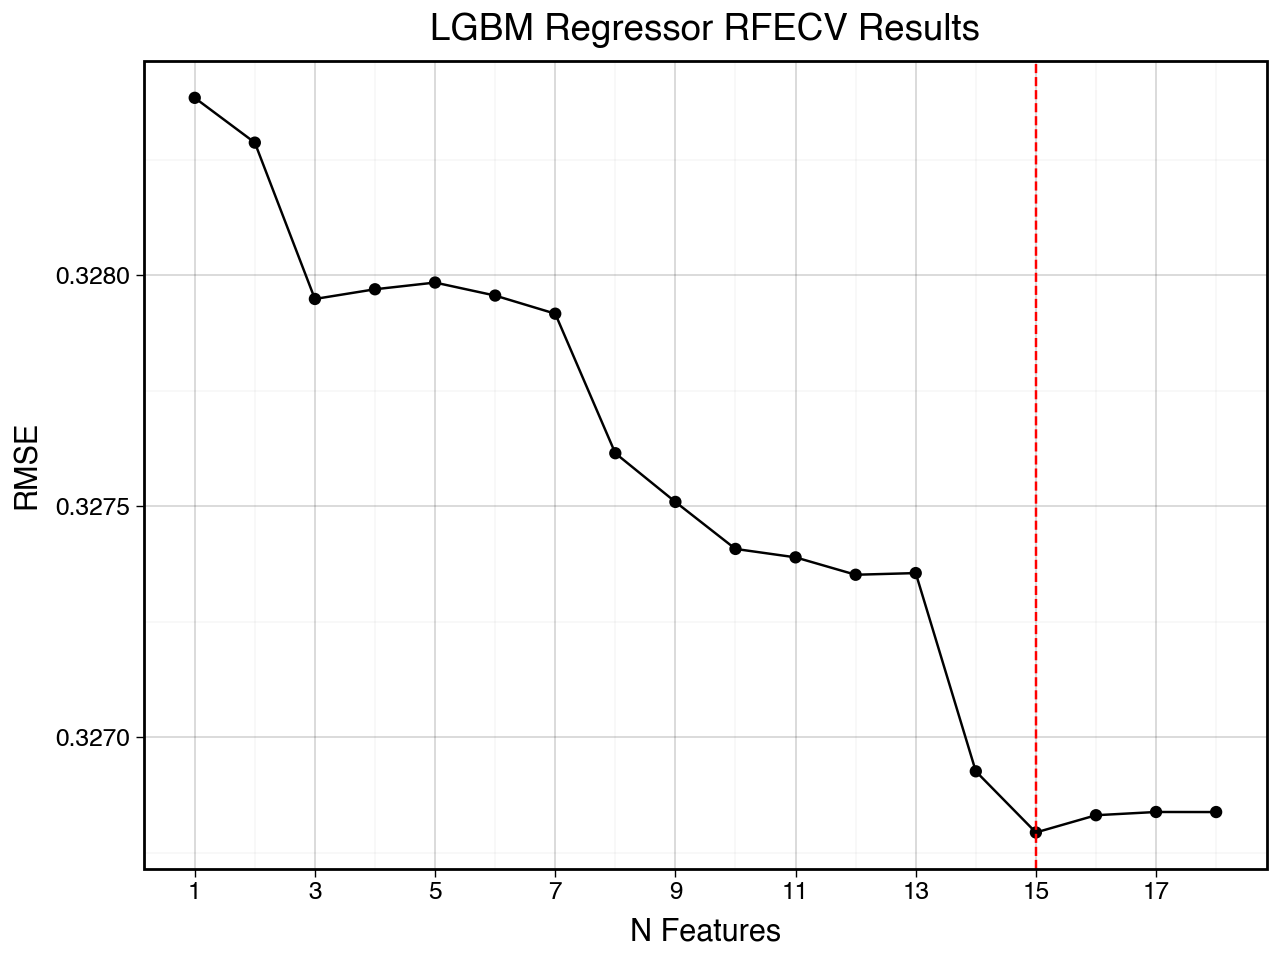

In [18]:
feature_selection_plot = (
    ggplot(
        pl.from_dict({
            "N Features": rfecv.cv_results_["n_features"].tolist(),
            "RMSE": (-rfecv.cv_results_["mean_test_score"]).tolist(),
        }),
        aes(x="N Features", y="RMSE")
    )
    + geom_point()
    + geom_line()
    + theme_linedraw()
    + geom_vline(xintercept=rfecv.n_features_, linetype="dashed", color="red")
    + scale_x_continuous(breaks=range(1, len(rfecv.cv_results_["mean_test_score"]), 2))
    + labs(title="LGBM Regressor RFECV Results")
)

feature_selection_plot.show()

Going with the elbow at 10 features, not the suggested number.

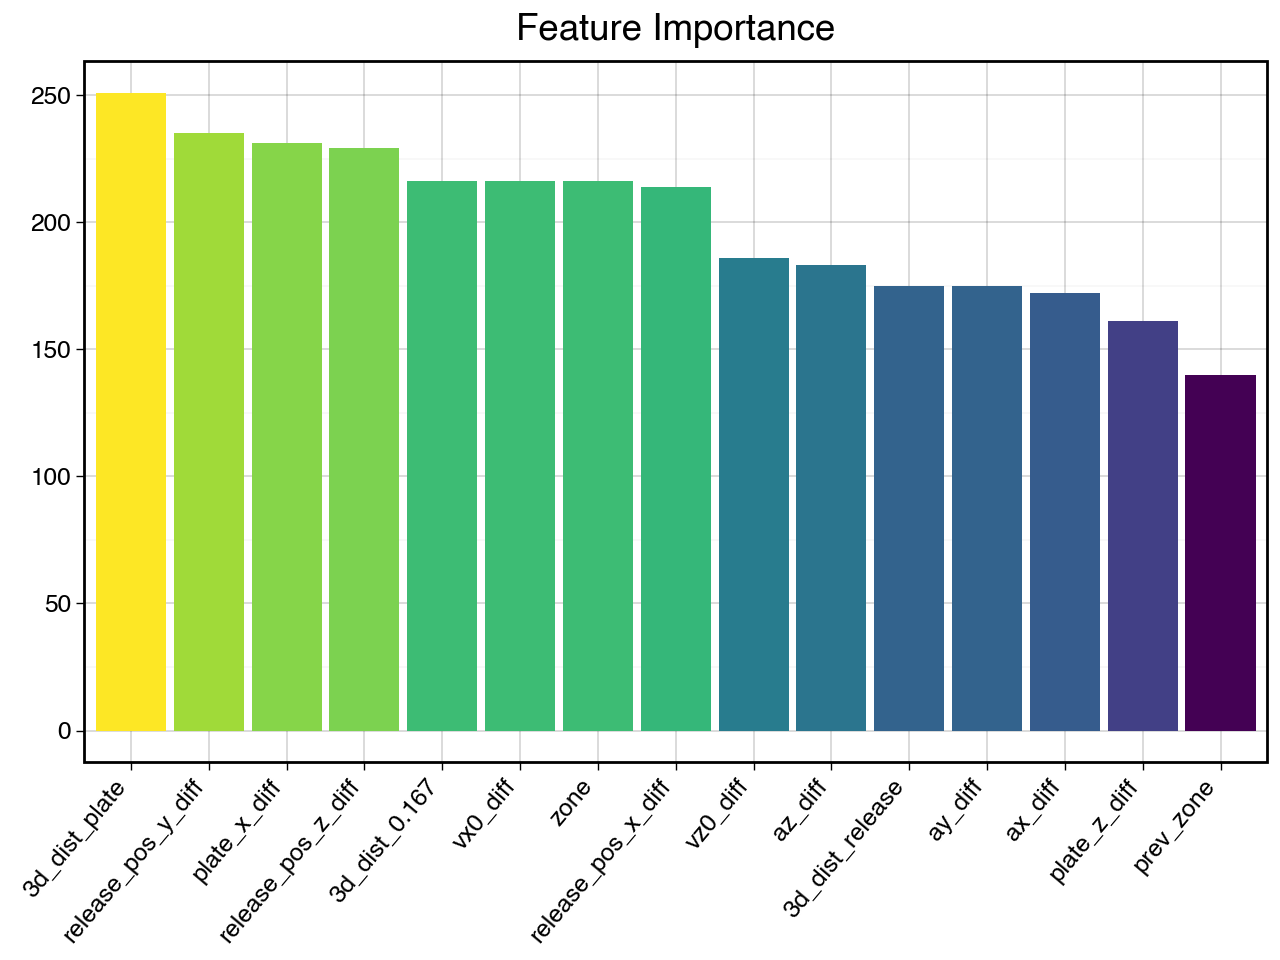

In [19]:
selected_feature_mask = np.where(rfecv.support_)[0]
SELECTED_FEATURES = [X_sample.columns[i] for i in selected_feature_mask[:rfecv.n_features_]]
feature_importances = rfecv.estimator_.feature_importances_[:rfecv.n_features_]

feature_df = pl.from_dict({
    "Feature": SELECTED_FEATURES,
    "RFECV Importance": feature_importances,
}).sort("RFECV Importance", descending=True)

feature_importance_plot = (
    ggplot(feature_df, aes(x="Feature", y="RFECV Importance"))
    + theme_linedraw()
    + geom_col(aes(fill="RFECV Importance"), stat="identity")
    + theme(axis_text_x=element_text(rotation=50, hjust=1))
    + guides(fill="none")
    + scale_x_discrete(limits=feature_df["Feature"].to_list())
    + labs(title="Feature Importance", x="", y="")
)

feature_importance_plot.show()

### Correlation Matrix

Each chunk represents the pearson correlation coefficient between two features

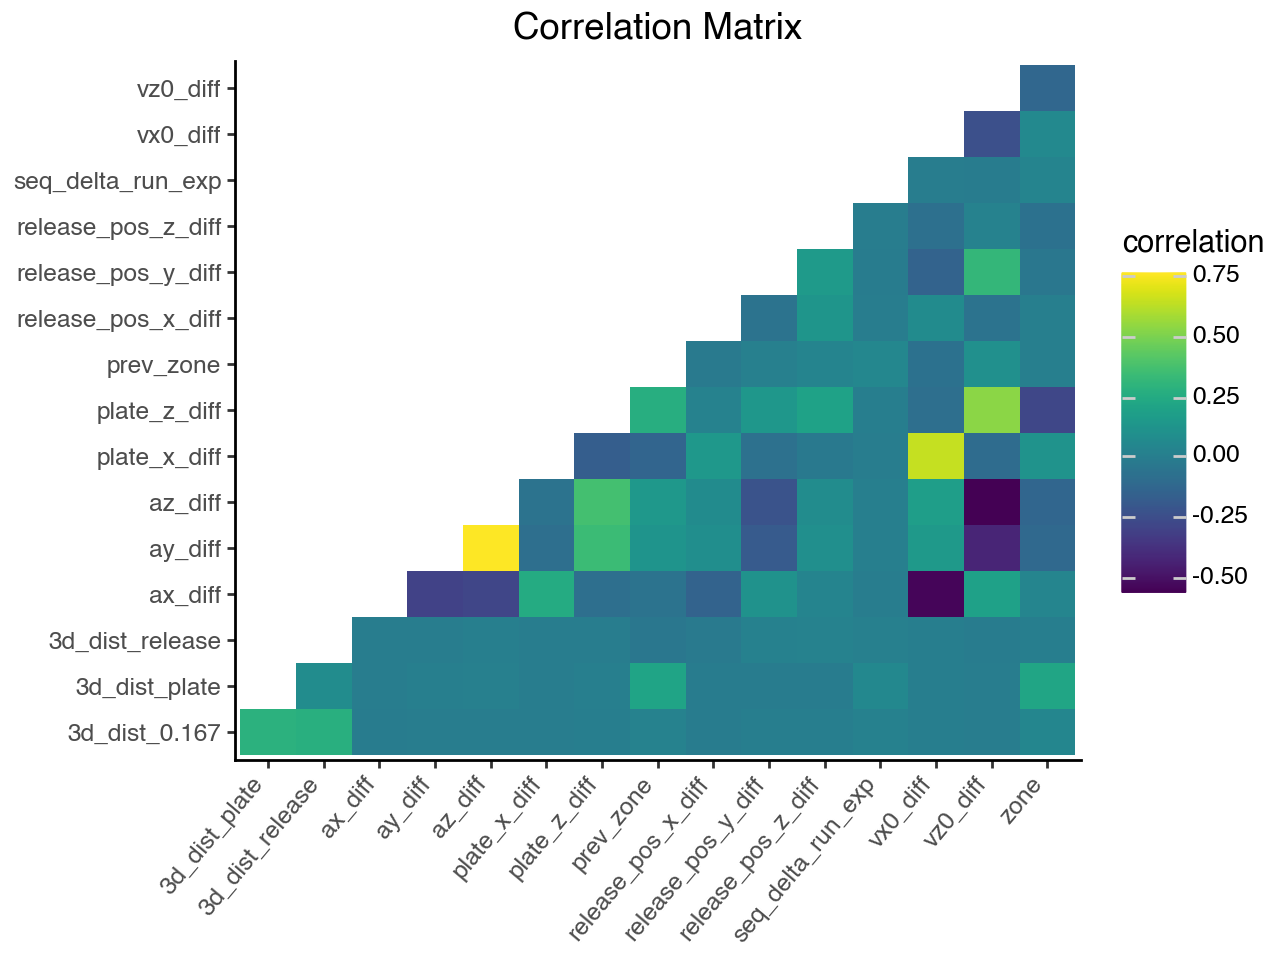

In [20]:
sample_corr_df = (two_seqs_df
                     .select(*SELECTED_FEATURES, RESPONSE)
                     .sample(200_000, seed=42)
                     .corr())

corr_matrix = (
    ggplot(
        sample_corr_df
        .with_columns(pl.Series("variable_1", sample_corr_df.columns))
        .unpivot(
            index="variable_1",
            variable_name="variable_2",
            on=sample_corr_df.columns,
            value_name="correlation",
        )
        .filter(pl.col("variable_1") > pl.col("variable_2")),
        aes(x="variable_1", y="variable_2", fill="correlation"),
    )
    + geom_tile(size=3)
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=50, hjust=1))
    + labs(
        title="Correlation Matrix",
        x="",
        y="",
    )
)

corr_matrix.show()

## Hyper Parameter Tuning w/ Optuna

In [21]:
# need to train test split the sample dataset
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    sample.select(*SELECTED_FEATURES), sample.select(RESPONSE),
    test_size=0.2,
    random_state=42,
)

X_train_sample = X_train_sample.to_numpy()
y_train_sample = y_train_sample.to_numpy().flatten()
X_test_sample = X_test_sample.to_numpy()
y_test_sample = y_test_sample.to_numpy().flatten()

def hyperparam_tuning_objective(trial):
    estimator = LGBMRegressor(
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.1),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 30),
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        reg_lambda=trial.suggest_float("reg_lambda", 0, 0.4),
        reg_alpha=trial.suggest_float("reg_alpha", 0, 0.4),
        max_depth=-1,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )

    pipeline = Pipeline([
        ("preprocessor", RobustScaler(copy=False)),
        ("model", estimator),
    ]) 

    pipeline.fit(X_train_sample, y_train_sample)
    e = y_test_sample - pipeline.predict(X_test_sample)
    return np.sqrt(np.mean(e**2))

study = optuna.create_study(direction="minimize")
study.optimize(hyperparam_tuning_objective, n_trials=50)

print(f"Best Parameters: {study.best_params}")
print(f"best RMSE: {study.best_value}")

[I 2024-11-18 00:04:09,173] A new study created in memory with name: no-name-b87c647f-1c29-4d75-8e68-ca169fde7775
[I 2024-11-18 00:04:12,947] Trial 0 finished with value: 0.327360673009527 and parameters: {'learning_rate': 0.08387582406981935, 'min_child_samples': 28, 'n_estimators': 560, 'reg_lambda': 0.3956477998581716, 'reg_alpha': 0.05563488479244541}. Best is trial 0 with value: 0.327360673009527.
[I 2024-11-18 00:04:16,525] Trial 1 finished with value: 0.3270338916034162 and parameters: {'learning_rate': 0.054456277311761975, 'min_child_samples': 16, 'n_estimators': 552, 'reg_lambda': 0.2996804531592178, 'reg_alpha': 0.36740007163814403}. Best is trial 1 with value: 0.3270338916034162.
[I 2024-11-18 00:04:18,338] Trial 2 finished with value: 0.32679276178117794 and parameters: {'learning_rate': 0.03845060615104571, 'min_child_samples': 12, 'n_estimators': 237, 'reg_lambda': 0.08221109830067297, 'reg_alpha': 0.17935730415672102}. Best is trial 2 with value: 0.32679276178117794.
[I

Best Parameters: {'learning_rate': 0.02703103804480939, 'min_child_samples': 22, 'n_estimators': 224, 'reg_lambda': 0.37569224834570747, 'reg_alpha': 0.13383703178260914}
best RMSE: 0.3267540130237858


# Training Final Model

In [22]:
final_pipeline = Pipeline([
    ("scaler", RobustScaler(copy=False)),
    ("model", LGBMRegressor(
        random_state=42,
        n_jobs=-1,
        max_depth=-1,
        **study.best_params,
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X.select(*SELECTED_FEATURES), y.select(RESPONSE),
    test_size=0.3,
    random_state=42,
)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

final_pipeline.fit(X_train, y_train)
print(f"RMSE: {rmse(y_test, final_pipeline.predict(X_test)):.3f}")

RMSE: 0.327


## Standardize

Center Sequence+ around 100

In [23]:
def predict_on_df(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        pl.Series(
            name="pred_seq_delta_run_exp",
            values=final_pipeline.predict(
                df.select(*SELECTED_FEATURES)
                .to_numpy()
            )
        )
    )

test_df_pred = test_df.pipe(predict_on_df)

# test_df_pred.select("pred_seq_delta_run_exp").describe()

In [24]:
def compute_sequence_plus(df: pl.DataFrame) -> pl.DataFrame:

    def get_zscores(df: pl.DataFrame) -> pl.DataFrame:
        return df.with_columns(
            ((pl.col("pred_seq_delta_run_exp") 
            - pl.col("pred_seq_delta_run_exp").mean())
            / pl.col("pred_seq_delta_run_exp").std())
            .alias("pred_seq_delta_run_exp_zscore")
        )

    return df.pipe(get_zscores).with_columns(
        (100 - (pl.col("pred_seq_delta_run_exp_zscore") * 10))
        # .round()
        .alias("Sequence+")
    )

test_sequence_df = test_df_pred.pipe(compute_sequence_plus)

(test_sequence_df
    .select("pred_seq_delta_run_exp",
            "pred_seq_delta_run_exp_zscore",
            "Sequence+")
    .describe())

statistic,pred_seq_delta_run_exp,pred_seq_delta_run_exp_zscore,Sequence+
str,f64,f64,f64
"""count""",740433.0,740433.0,740433.0
"""null_count""",0.0,0.0,0.0
"""mean""",-0.002403,4.6293e-17,100.0
"""std""",0.032552,1.0,10.0
"""min""",-0.095849,-2.870625,41.859764
"""25%""",-0.026204,-0.731172,93.71077
"""50%""",-0.004199,-0.05519,100.5519
"""75%""",0.01807,0.628923,107.311716
"""max""",0.186858,5.814024,128.706255


In [25]:
(test_sequence_df
    .write_parquet(
        os.path.join(DATA_DIR, "2024_sequence+_pitches.parquet")
    ))

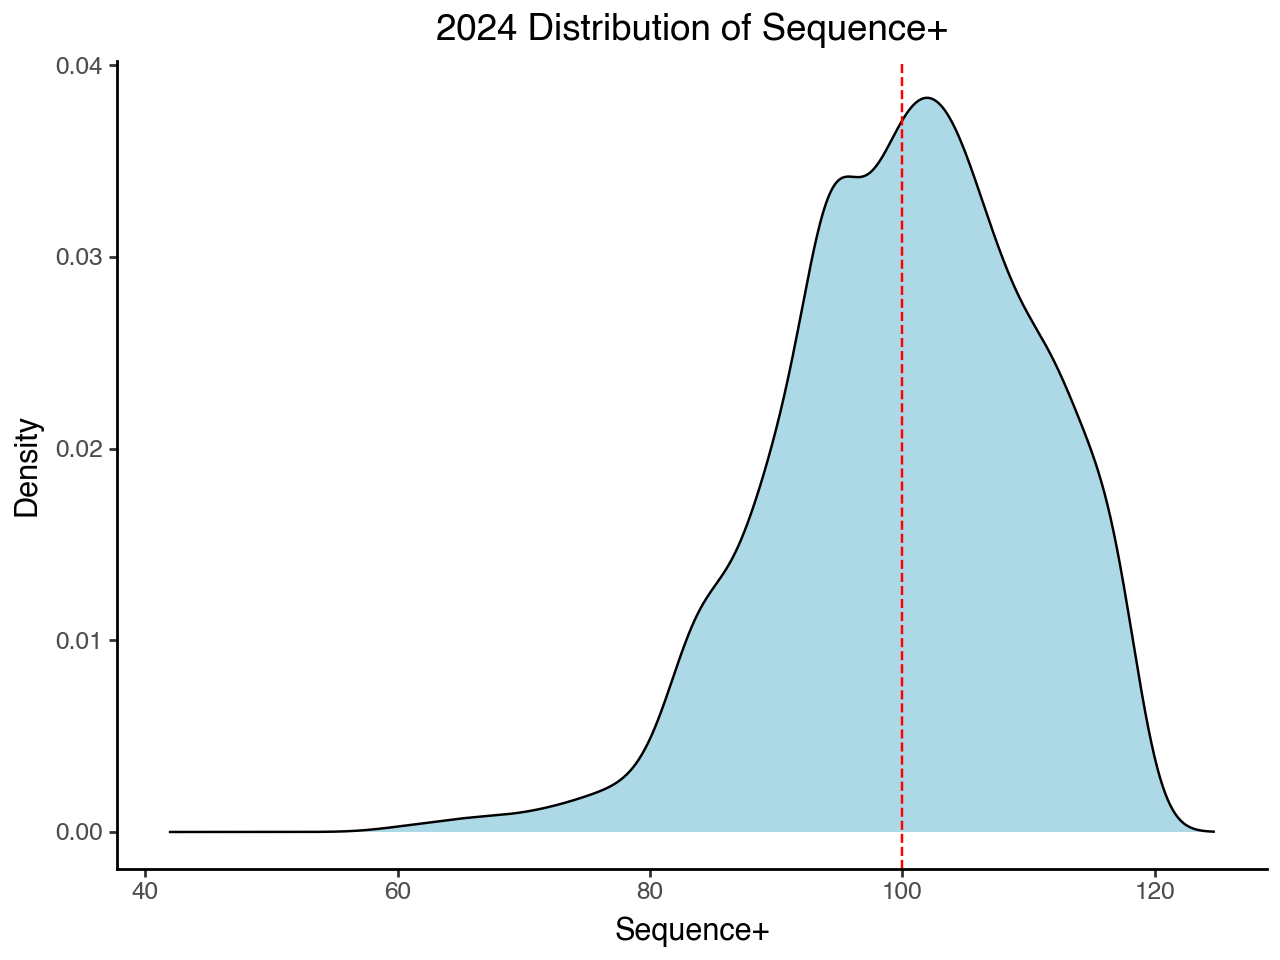

In [26]:
pred_dist_plot = (
    ggplot(
        test_sequence_df
        .filter(pl.col("pitch_type").is_in(pitch_types)), 
        aes(x="Sequence+"))
    + geom_density(adjust=3, fill="lightblue")
    + theme_classic()
    + geom_vline(xintercept=test_sequence_df["Sequence+"].mean(), linetype="dashed", color="red")
    + labs(
        title="2024 Distribution of Sequence+",
        x="Sequence+",
        y="Density",
    )
)

pred_dist_plot.show()

# Evaluating Sequence+

analyze correlations between Sequence+ and other descriptive/predictive MLB metrics like FIP, 

In [32]:
fg_24 = (pl.from_pandas(pybaseball.pitching_stats(2024))
         .with_columns(
          pl.col("Name").str.split(" ").list.get(0).alias("first_name"),
          pl.col("Name").str.split(" ").list.get(1).alias("last_name")
         )
         .with_columns(
             (pl.col("last_name") + ", " + pl.col("first_name"))
             .alias("player_name")
         ))

pitches_24_df = (pl.LazyFrame
                 .deserialize(os.path.join(DATA_DIR, "two_pitch_seqs_lf"))
                 .filter(pl.col("game_date").dt.year() == 2024)
                 .collect()
                 .pipe(predict_on_df)
                 .pipe(compute_sequence_plus)
                 .with_columns(
                     (pl.col("prev_pitch_type") + "-" + pl.col("pitch_type"))
                     .alias("combo")
                 )
                 .group_by("pitcher", "player_name")
                 .agg(
                    pl.len().alias("n"),
                    pl.col("Sequence+").mean().alias("Mean Sequence+"),
                 )
                 .filter(pl.col("n") >= 50)
                 .join(
                     other=fg_24,
                     on="player_name",
                     how="inner",
                 )
                 .sort("Mean Sequence+", descending=True))

pitches_24_df.head(10)

pitcher,player_name,n,Mean Sequence+,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,…,botCmd FS,botOvr,botStf,botCmd,botxRV100,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO,first_name,last_name
i64,str,u32,f64,i64,i64,str,str,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,str,str
592791,"""Taillon, Jameson""",2483,101.94826,11674,2024,"""Jameson Taillon""","""CHC""",32,12,8,2.3,3.27,28,28,0,0,0,0,165.1,675,154,67,60,21,33,0,1,4,2,125,204,206,99,14,833,1650,…,null,56,41,65,-0.24,78.0,102.0,95.0,104.0,111.0,113.0,66.0,106.0,96.0,74.0,104.0,92.0,104.0,116.0,120.0,null,null,null,92.0,103.0,98.0,null,null,null,85,107,102,null,null,null,"""Jameson""","""Taillon"""
663623,"""Irvin, Jake""",3124,101.581537,21504,2024,"""Jake Irvin""","""WSN""",27,10,14,1.8,4.41,33,33,0,0,0,0,187.2,769,173,97,92,29,52,1,4,5,1,156,243,203,107,16,1061,1985,…,null,53,45,57,-0.06,99.0,91.0,93.0,110.0,104.0,106.0,82.0,104.0,97.0,97.0,102.0,102.0,110.0,115.0,117.0,null,null,null,78.0,102.0,93.0,null,null,null,94,103,101,null,null,null,"""Jake""","""Irvin"""
543243,"""Gray, Sonny""",2483,101.508287,12768,2024,"""Sonny Gray""","""STL""",34,13,9,3.8,3.84,28,28,0,0,0,0,166.1,671,142,79,71,21,39,0,3,7,1,203,176,147,93,11,835,1651,…,null,62,58,54,-0.61,69.0,91.0,86.0,119.0,96.0,97.0,107.0,97.0,101.0,93.0,114.0,112.0,152.0,114.0,125.0,null,null,null,92.0,98.0,96.0,null,null,null,110,103,105,null,null,null,"""Sonny""","""Gray"""
669923,"""Kirby, George""",3035,101.454294,25436,2024,"""George Kirby""","""SEA""",26,14,11,4.2,3.53,33,33,0,0,0,0,191.0,778,181,82,75,22,23,0,7,5,1,179,232,229,101,25,937,2032,…,49.0,61,53,62,-0.54,null,null,null,null,null,null,102.0,107.0,101.0,106.0,108.0,108.0,110.0,104.0,110.0,114.0,110.0,113.0,97.0,99.0,93.0,109.0,100.0,108.0,106,106,106,null,null,null,"""George""","""Kirby"""
663372,"""Feltner, Ryan""",2721,101.399809,21446,2024,"""Ryan Feltner""","""COL""",27,3,10,2.4,4.49,30,30,0,0,0,0,162.1,692,165,94,81,20,52,0,7,4,0,138,221,173,98,13,918,1662,…,null,48,43,51,0.24,117.0,95.0,102.0,108.0,107.0,113.0,81.0,102.0,96.0,93.0,93.0,89.0,109.0,99.0,104.0,null,null,null,null,null,null,null,null,null,97,100,99,null,null,null,"""Ryan""","""Feltner"""
656605,"""Keller, Mitch""",2903,101.348529,17594,2024,"""Mitch Keller""","""PIT""",28,11,12,2.2,4.25,31,31,1,0,0,0,178.0,773,182,90,84,23,50,0,15,1,2,166,212,198,128,16,962,1890,…,null,54,47,56,-0.12,88.0,103.0,102.0,111.0,96.0,104.0,86.0,103.0,96.0,82.0,102.0,94.0,129.0,100.0,109.0,null,null,null,96.0,99.0,98.0,null,null,null,99,101,100,null,null,null,"""Mitch""","""Keller"""
641927,"""Ober, Bailey""",2738,101.348253,21224,2024,"""Bailey Ober""","""MIN""",28,12,9,2.9,3.98,31,31,1,0,0,0,178.2,709,136,81,79,27,43,0,6,1,0,191,156,234,75,24,876,1821,…,null,57,48,65,-0.3,116.0,111.0,111.0,94.0,99.0,103.0,81.0,104.0,96.0,null,null,null,74.0,100.0,101.0,null,null,null,84.0,104.0,100.0,null,null,null,91,105,102,null,null,null,"""Bailey""","""Ober"""
676710,"""Crawford, Kutter""",2906,101.347874,20531,2024,"""Kutter Crawford""","""BOS""",28,9,16,1.9,4.36,33,33,0,0,0,0,183.2,759,155,97,89,34,51,0,9,4,0,175,171,256,91,37,911,1912,…,48.0,58,45,58,-0.34,null,null,null,null,null,null,109.0,109.0,112.0,null,null,null,100.0,99.0,102.0,98.0,97.0,99.0,114.0,104.0,104.0,87.0,102.0,106.0,108,105,107,null,null,null,"""Kutter""","""Crawford"""
605400,"""Nola, Aaron""",3354,101.207061,16149,2024,"""Aaron Nola""","""PHI""",31,14,8,3.2,3.57,33,33,1,1,0,0,199.1,820,189,84,79,30,50,0,3,2,0,197,252,192,122,16,1101,2092,…,null,57,49,61,-0.3,78.0,102.0

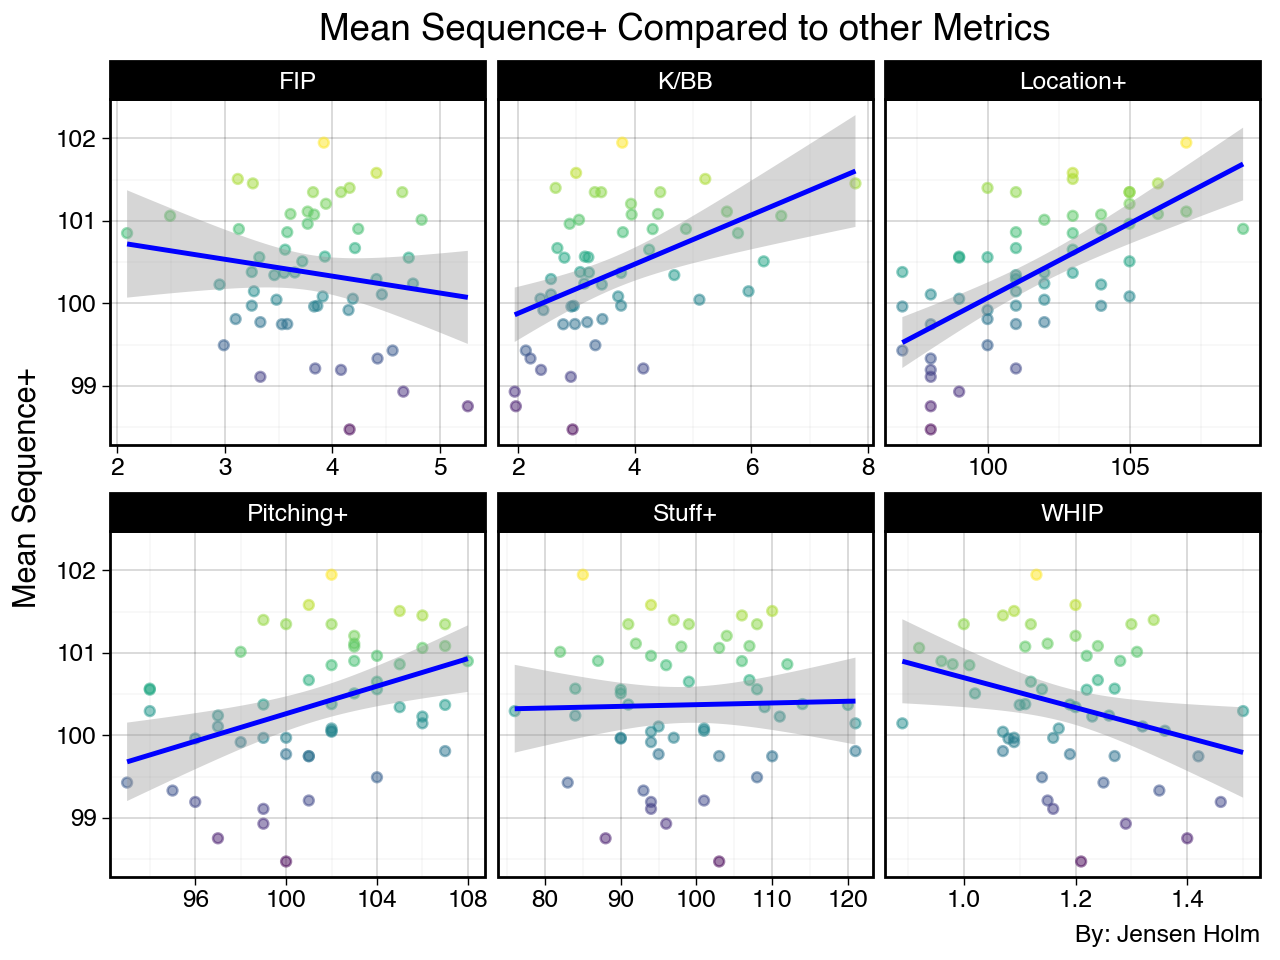

In [33]:
sequence_p_eval = (
    ggplot(
        pitches_24_df
        .unpivot(
            index=["Mean Sequence+"],
            on=["FIP", "WHIP", "Pitching+", "Stuff+", "Location+", "K/BB"]
        ),
        aes(x="value", y="Mean Sequence+", color="Mean Sequence+")
    )
    + geom_point(alpha=0.5)
    + geom_smooth(method="lm", color="blue")
    + facet_wrap("~ variable", scales="free_x")
    + guides(color="none")
    + theme_linedraw()
    + labs(
        title="Mean Sequence+ Compared to other Metrics",
        x="",
        caption="By: Jensen Holm",
    )
)

sequence_p_eval.show()

In [34]:
# joblib.dump(
#     final_pipeline, 
#     os.path.join("..", "models", "Sequence+1.0.joblib"),
# )